# Введение в искусственные нейронные сети
# Урок 5. Метод обратного распространения ошибки

## Практическое задание

1. Проверить как идет обучение при различных параметрах модели для выборки "Ирисы Фишера":
    
    - Измените размер batch_size : 1, 10, 20, 50
    
    - измените значение lyambd: 0.01, 0.1, 0.5, 1 
    
    - измените число нейронов в скрытом слое : 1, 5, 50

2. Сделайте несколько перезапусков каждой модели (10 перезапусков с вычислением среднего и дисперсии для оценки точности).

3. Оцените изменения параметров статистик точности при изменении параметров модели. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import warnings

%matplotlib inline

In [2]:
### Определение функций, которые понадобяться для обучения
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = layer2[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1 - sigmoid(x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

In [3]:
### Функция обучения нейронной сети с возможностью задания параметров
def train_nn(X_train, y_train, X_test=None, y_test=None,
             n=0.1, H=5, batch_size=10, epochs=5000, lambda_=0.1, random_state=21):
    
    np.random.seed(random_state)
    
    J = X_train.shape[1] # нейронов во входном слое
    M = y_train.shape[1] # нейронов в выходном слое
    
    w0 = 2 * np.random.random((J, H)) - 1 # веса нейронов входного слоя
    w1 = 2 * np.random.random((H, M)) - 1 # веса нейронов скрытого слоя
    
    # Ошибки на обучении и тесте
    errors = []
    Q = None
    errors_test = []
    
    for i in range(epochs):
        
        # Индексы объектов на обучение
        samples = np.random.randint(0, X_train.shape[0], int(batch_size))

        # прямое распространение(feed forward)
        layer0 = X_train[samples, :]
        layer1 = sigmoid(np.dot(layer0, w0))
        layer2 = sigmoid(np.dot(layer1, w1))

        # обратное распространение(back propagation) с использованием градиентного спуска
        layer2_error = y_train[samples, :] - layer2
        layer2_delta = layer2_error * sigmoid_deriv(layer2)
    
        layer1_error = layer2_delta.dot(w1.T)
        layer1_delta = layer1_error * sigmoid_deriv(layer1)

        w1 += layer1.T.dot(layer2_delta) * n
        w0 += layer0.T.dot(layer1_delta) * n
        
        # Ошибка на обучении
        error = np.mean(np.abs(layer2_error))
        if not Q:
            Q = error
        else:
            Q = Q * (1 - lambda_) + lambda_ * error             
        errors.append(Q)
        
        # Проверка на тесте (и ошибка)
        layer0_test = X_test
        layer1_test = sigmoid(np.dot(layer0_test, w0))
        layer2_test = sigmoid(np.dot(layer1_test, w1))
        
        layer2_error_test = y_test - layer2_test
        error_test = np.mean(np.abs(layer2_error_test))
        errors_test.append(error_test)
    
    accuracy = (1 - error) * 100
    accuracy_test = (1 - error_test) * 100
    
    return accuracy, accuracy_test, errors, errors_test

In [4]:
### Загрузка и разбиение данных
iris_data = load_iris()

x = normalize(iris_data['data'])
y = to_one_hot(iris_data['target'])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

**Параметры сети для изменения**

In [5]:
batch_sizes = [1, 10, 20, 50] # размер подвыборки, после которого веса сети обновляются
lambdas = [0.01, 0.1, 0.5, 1] # коэффициент, регуляризующий ошибку обучения
Hs = [1, 5, 50]               # количество нейронов в скрытом слое

**Построим графики зависимости ошибок на обучении и тесте от изменяемых параметров сети**

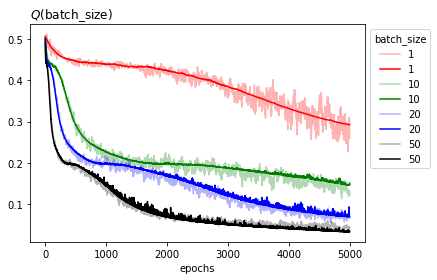

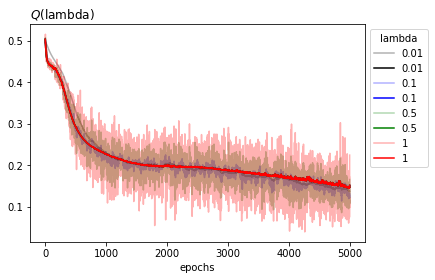

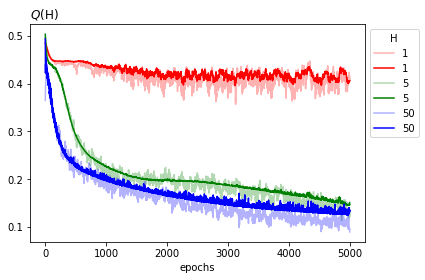

In [6]:
for batch_size, c in zip(batch_sizes, ['r', 'g', 'b', 'k']):
    errors, errors_test = train_nn(X_train, y_train,
                                   X_test, y_test,
                                   batch_size=batch_size)[-2:]
    label = str(batch_size)
    plt.plot(errors, c=c, alpha=0.3, label=label)
    plt.plot(errors_test, c=c, alpha=1, label=label)
plt.title('$Q$(batch_size)', loc='left')
plt.xlabel('epochs')
plt.legend(bbox_to_anchor=(1., 1.), title='batch_size')
plt.show()

for lambda_, c in zip(lambdas, ['k', 'b', 'g','r']):
    errors, errors_test = train_nn(X_train, y_train,
                                   X_test, y_test,
                                   lambda_=lambda_)[-2:]
    label = str(lambda_)
    plt.plot(errors, c=c, alpha=0.3, label=label)
    plt.plot(errors_test, c=c, alpha=1, label=label)
plt.title('$Q$(lambda)', loc='left')
plt.xlabel('epochs')
plt.legend(bbox_to_anchor=(1., 1.), title='lambda')
plt.show()

for H, c in zip(Hs, ['r', 'g', 'b']):
    errors, errors_test = train_nn(X_train, y_train,
                                   X_test, y_test,
                                   H=H)[-2:]
    label = str(H)
    plt.plot(errors, c=c, alpha=0.3, label=label)
    plt.plot(errors_test, c=c, alpha=1, label=label)
plt.title('$Q$(H)', loc='left')
plt.xlabel('epochs')
plt.legend(bbox_to_anchor=(1., 1.), title='H')
plt.show()

*Бледный график - обучение, жирный - тест.*

 - Увеличение batch_size уменьшает значение ошибки на обучении и тесте;
 - Увеличение lambda не сказывается на ошибке на тесте, но увеличивает разброс ошибки на обучении - это принципиально в случае, если критерий останова обучения сети определяется именно ею;
 - Увеличение H повысило качество работы сети на обучении и на тесте - при этом значения 5 и 50 нейронов дают близкий результат.

**С каждым значением из изменяемых параметров произведём 10 обучений сети и рассчитаем среднее и СКО по полученным 10 значениям доли правильных ответов на тесте.**

**Построим графики зависимости среднего и СКО доли от изменяемых параметров.**

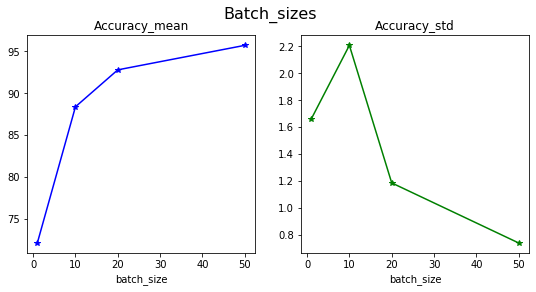

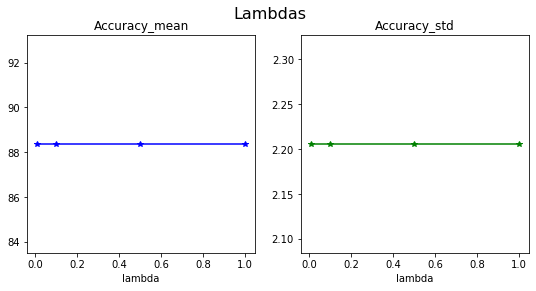

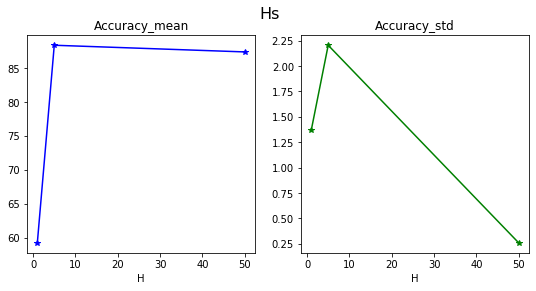

In [7]:
random_states = range(10)

accuracy_means, accuracy_stds = [], []
for batch_size in batch_sizes:
    accuracies = []
    for rs in random_states:
        accuracy_test = train_nn(X_train, y_train,
                                 X_test, y_test,
                                 batch_size=batch_size,
                                 random_state=rs)[1]
        accuracies.append(accuracy_test)
    accuracy_means.append(np.mean(accuracies))
    accuracy_stds.append(np.std(accuracies, ddof=1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
for stats, title, c, ax in zip([accuracy_means, accuracy_stds],
                               ['Accuracy_mean', 'Accuracy_std'],
                               ['b', 'g'], axes):
    ax.plot(batch_sizes, stats, c=c, marker='*')
    ax.set_title(title)
    ax.set_xlabel('batch_size')
fig.suptitle('Batch_sizes', size=16);
    
accuracy_means, accuracy_stds = [], []
for lambda_ in lambdas:
    accuracies = []
    for rs in random_states:
        accuracy_test = train_nn(X_train, y_train,
                                 X_test, y_test,
                                 lambda_=lambda_,
                                 random_state=rs)[1]
        accuracies.append(accuracy_test)
    accuracy_means.append(np.mean(accuracies))
    accuracy_stds.append(np.std(accuracies, ddof=1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
for stats, title, c, ax in zip([accuracy_means, accuracy_stds],
                               ['Accuracy_mean', 'Accuracy_std'],
                               ['b', 'g'], axes):
    ax.plot(lambdas, stats, c=c, marker='*')
    ax.set_title(title)
    ax.set_xlabel('lambda')
fig.suptitle('Lambdas', size=16);

accuracy_means, accuracy_stds = [], []
for H in Hs:
    accuracies = []
    for rs in random_states:
        accuracy_test = train_nn(X_train, y_train,
                                 X_test, y_test,
                                 H=H, random_state=rs)[1]
        accuracies.append(accuracy_test)
    accuracy_means.append(np.mean(accuracies))
    accuracy_stds.append(np.std(accuracies, ddof=1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
for stats, title, c, ax in zip([accuracy_means, accuracy_stds],
                               ['Accuracy_mean', 'Accuracy_std'],
                               ['b', 'g'], axes):
    ax.plot(Hs, stats, c=c, marker='*')
    ax.set_title(title)
    ax.set_xlabel('H')
fig.suptitle('Hs', size=16);

 - С увеличением batch_size увеличивается средняя доля правильных ответов, и уменьшается ее разброс;
 - Параметр lambda не влияет на ошибку на тесте;
 - Увеличение H повысило среднюю долю правильных ответов - хотя значения 5 и 50 нейронов дают близкий результат, при 50 нейронах разброс существенно меньше (т.е. сеть смогла исчерпывающе запомнить особенности ирисов).